# Install libraries

First we install the packages and Mount the google drive as follows:

In [ ]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/mydir')

# Define the path for the folder where you want to clone the repository
folder_path = '/content/mydir/MyDrive/qheom'

# Create the folder if it doesn't already exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Created folder: {folder_path}")

# Change the current working directory to the folder where you want to clone the repository
os.chdir(folder_path)

# Clone the GitHub Repository into the specified folder
#!git clone https://github.com/XiaohanDan97/QHEOM .

Mounted at /content/mydir
fatal: destination path '.' already exists and is not an empty directory.


In [ ]:
!pip install qiskit==1.2.4
!pip install qiskit_aer==0.15.1
!pip install qiskit-ibm-runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.8/340.8 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 13.4 MB/s eta 0:00:00


#Import functions, read the propagator and parameters

In [ ]:
#the code in the folder
import qfunc as qf
import dilate_circuit as dc
import walsh_gray_optimization as wo

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer import AerSimulator,QasmSimulator
from qiskit.quantum_info.operators import Operator

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_ibm_runtime.fake_provider import FakePerth, FakeLimaV2

In [ ]:
s1 = ' '
class Parameter:

  #the number of electronic states
  ndvr = 7
  #the length of Reduced Density Matrix
  Nmat = ndvr
  #number of steps for propagator G(t)
  Nstep = 1000

  #initial the rho(t=0) at first excited state |1>
  pop0 = np.zeros((Nmat),dtype=np.complex128)
  pop0[0] = 1.0

  def __init__(self, mode="pop_2qubit",proj_state_list = [0,1,2,5]):
    #the projection subspace
    self.proj_state_list = proj_state_list
    self.mode = mode

    if(mode=="pop_2qubit"):
      #the number of qubits for the vectorize state vector
      self.Nqubit = 2
      self.site_dict = {1:'00',2:'01',3:'10',4:'11'}
    if(mode=="pop_1qubit"):
      self.Nqubit = 1
      self.site_dict = {1:'0',2:'1'}

    #the length of statevector
    self.Nvec = 2**self.Nqubit

    #setup the vector from the initial rho
    self.ini_state = np.zeros(self.Nvec,dtype=np.complex128)
    self.ini_state[0] = 1.0

    self.norm_rho0 = LA.norm(self.ini_state,2)
    self.ini_state /= self.norm_rho0


#mode = "pop_2qubit" for 2qubit circuit
#mode = "pop_1qubit" for 1qubit circuit
#proj_state_list stand for projection subspace
#proj_state_list = [0,1,2,5] stand for S={11,22,33,66}
#proj_state_list = [0,1] stand for S={11,22}
#proj_state_list = [0,2] stand for S={11,33}
#proj_state_list = [0,5] stand for S={11,66}

pa=Parameter(mode = "pop_2qubit", proj_state_list=[0,1,2,5])
#pa=Parameter(mode = "pop_1qubit", proj_state_list=[0,1])
#pa=Parameter(mode = "pop_1qubit", proj_state_list=[0,2])
#pa=Parameter(mode = "pop_1qubit", proj_state_list=[0,5])

read the propagator from HEOM calculation

In [ ]:
os.chdir('./Gt_FMO_ne3nr30nb20')
folder_name=os.getcwd()
print('folder now',folder_name)
time, Gt0 = qf.read_superoper_array(pa.Nstep,pa)
os.chdir('../')

Gt = qf.proj(Gt0,pa.proj_state_list)

folder now /content/mydir/MyDrive/qheom/Gt_FMO_ne3nr30nb20


#Classical part
calculate the time evolution of state vector from propagator:
$|\Phi(t)\rangle = G(t) |\Phi(0)\rangle$

In [ ]:
popt = np.zeros((pa.Nvec,pa.Nstep),dtype=np.complex128)

for istep in range(pa.Nstep):
 vec_pop = Gt[istep,:,:]@pa.ini_state
 popt[:,istep] = vec_pop

print('the classical propagation done')

the classical propagation done


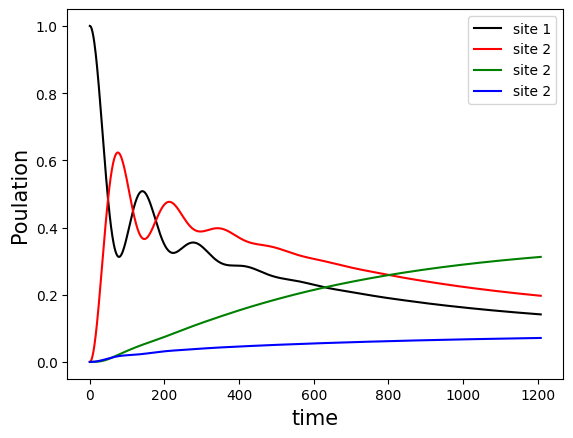

In [ ]:
plt.plot(time, popt[0,:].real,'k-', label = "site 1")
plt.plot(time, popt[1,:].real,'r-', label = "site 2")
plt.plot(time, popt[2,:].real,'g-', label = "site 2")
plt.plot(time, popt[3,:].real,'b-', label = "site 2")
plt.xlabel('time',fontsize=15)
plt.ylabel('Poulation',fontsize=15)
plt.legend(loc = 'upper right')

#General functions of the quantum circuit

##measure the circuit with ancilla at |0>

In [ ]:
#function for measure all the qubits with ancilla at |0>
def measure_all(Nqb,cirq,Simulator,Nshots):
  cirq.measure(range(Nqb),range(Nqb))
  #using a simulator to run the circuit?
  job = Simulator.run(cirq, shots=Nshots)
  count=job.result().get_counts(cirq)

  pop_tmp = np.zeros((pa.Nvec),dtype=np.float_)
  #Population
  for key in pa.site_dict:
    if('0'+pa.site_dict[key] in count):
      pop_tmp[key-1] = np.sqrt((count['0'+pa.site_dict[key]])/Nshots) #0 for dilation
    else:
      pop_tmp[key-1] = 0.0

  return pop_tmp

#function for measure all the qubits with ancilla at |0>
#writtern for qiskit Sampler primitives
def measure_sampler(Nqb,cirq_list,sampler,Nshots):

  Ncirq = len(cirq_list)

  #using a simulator to run the circuit?
  job = sampler.run(cirq_list,shots=Nshots)

  pop_tmp = np.zeros((Ncirq,pa.Nvec),dtype=np.float_)

  for iqc in range(Ncirq):

    count = job.result()[iqc].data.meas.get_counts()

    #Population
    for key in pa.site_dict:
      if('0'+pa.site_dict[key] in count):
        pop_tmp[iqc,key-1] = np.sqrt((count['0'+pa.site_dict[key]])/Nshots) #0 for dilation
      else:
        pop_tmp[iqc,key-1] = 0.0

  return pop_tmp

##construct circuit

In [ ]:
#construct the quantum circuit list from the Walsh operator method
#time, G: time array and propagator matrix
def cons_qcsampler_walsh(timearr, G, Nlen, backend = AerSimulator(), level = 1, Nrepeat = 10):

  vrho_dil = np.concatenate((pa.ini_state.copy(),np.zeros(pa.Nvec)))

  nlarge = int(len(timearr)/(Nlen-1))
  time_q = np.zeros(Nlen)

  normfac_list = []; qc_list = []
  for i0 in range(Nlen):

    istep = i0*nlarge
    time_q[i0] = timearr[istep]

    depth = 1000
    for j in range(Nrepeat):

      #different dilation method
      qc2,normfac = dc.SVD_walsh_cirq(pa.Nqubit+1,G[istep],vrho_dil)
      #qc2,normfac = dc.dilation_SVD_cirq(pa.Nqubit+1,G[istep],vrho_dil)
      #qc2,normfac = dc.Sz_Nagi_cirq(pa.Nqubit+1,G[istep],vrho_dil)
      qc2.measure_all()
      qc = transpile(qc2,backend,optimization_level=level)
      if(qc.depth()<depth):
        depth = qc.depth()
        qc0 = qc
        print('istep',i0,'j',j,'depth',qc0.depth())

    normfac_list.append(normfac); qc_list.append(qc0)

    print('istep', i0, 'depth', qc.depth(),normfac*pa.norm_rho0)
  return time_q, qc_list, normfac_list

##simulator  primitives

In [ ]:
#The sampler simulation of the quantum circuit
def qcsampler(qc_list, normfac_list, backend= AerSimulator(), Nshots = 2000):
  Nlen = len(qc_list)
  sampler = Sampler(mode=backend)

  # Estimator and Sampler have different options
  options = sampler.options

  #error mitigation
  options.dynamical_decoupling.enable = True
  options.twirling.enable_gates = True
  #options.twirling.enable_measure = True

  pa_tmp = measure_sampler(pa.Nqubit+1,qc_list,sampler,Nshots)

  Pa_q = np.zeros((Nlen,pa.Nvec))
  for i0 in range(Nlen):
    Pa_q[i0] = pa_tmp[i0]*normfac_list[i0]*pa.norm_rho0

  return Pa_q

#Simulation

In [ ]:
backend_sim = QasmSimulator()
nshots_sim = 20000
ncirq_sim = 44

In [ ]:
time_q1, qc_list1, normfac_list1 = cons_qcsampler_walsh(time, Gt, ncirq_sim, backend = AerSimulator(), level=0, Nrepeat=1)

istep 0 j 0 depth 3
istep 0 depth 3 1.0
istep 1 j 0 depth 11
istep 1 depth 11 0.9854767127687231
istep 2 j 0 depth 11
istep 2 depth 11 0.9579263467376015
istep 3 j 0 depth 11
istep 3 depth 11 0.9320688084768658
istep 4 j 0 depth 11
istep 4 depth 11 0.909432210836467
istep 5 j 0 depth 11
istep 5 depth 11 0.889498292657751
istep 6 j 0 depth 11
istep 6 depth 11 0.8717343509195087
istep 7 j 0 depth 11
istep 7 depth 11 0.8564875592353082
istep 8 j 0 depth 11
istep 8 depth 11 0.8434744653023087
istep 9 j 0 depth 11
istep 9 depth 11 0.8320204158794899
istep 10 j 0 depth 11
istep 10 depth 11 0.8218045954434554
istep 11 j 0 depth 11
istep 11 depth 11 0.8127877271532573
istep 12 j 0 depth 11
istep 12 depth 11 0.8051795255908308
istep 13 j 0 depth 11
istep 13 depth 11 0.7990061233205389
istep 14 j 0 depth 11
istep 14 depth 11 0.7940180888318694
istep 15 j 0 depth 11
istep 15 depth 11 0.7899222024253945
istep 16 j 0 depth 11
istep 16 depth 11 0.7865530029171367
istep 17 j 0 depth 11
istep 17 depth

In [ ]:
Pa_q1 = qcsampler(qc_list1, normfac_list1, backend= backend_sim, Nshots = nshots_sim)

/usr/local/lib/python3.10/dist-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True}, 'twirling': {'enable_gates': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


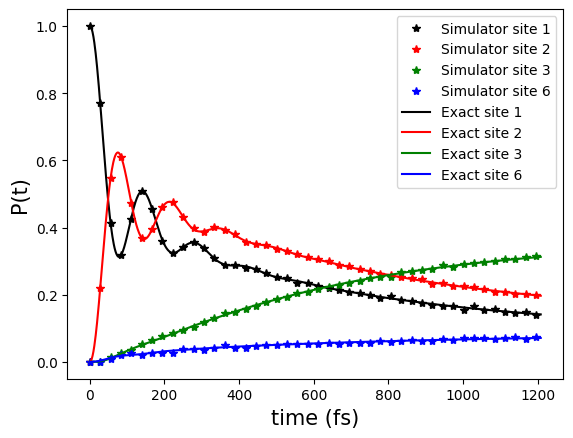

In [ ]:
#2 qubit case
plt.plot(time_q1, Pa_q1[:,0],'k*',label = 'Simulator site 1')
plt.plot(time_q1, Pa_q1[:,1],'r*',label = 'Simulator site 2')
plt.plot(time_q1, Pa_q1[:,2],'g*',label = 'Simulator site 3')
plt.plot(time_q1, Pa_q1[:,3],'b*',label = 'Simulator site 6')

plt.plot(time, popt[0,:].real,'k-', label = "Exact site 1")
plt.plot(time, popt[1,:].real,'r-', label = "Exact site 2")
plt.plot(time, popt[2,:].real,'g-', label = "Exact site 3")
plt.plot(time, popt[3,:].real,'b-', label = "Exact site 6")
plt.xlabel('time (fs)',fontsize=15)
plt.ylabel('P(t)',fontsize=15)
plt.legend(loc = 'upper right')

#Run the circuit in real quantum computer

In [ ]:
#you'll need to create an IBM Cloud account and a quantum service instance.
#replace "MY_IBM_QUANTUM_TOKEN" to your IBM Cloud accound token
service = QiskitRuntimeService(channel="ibm_quantum", token="MY_IBM_QUANTUM_TOKEN")

# get a real backend from the runtime service
backend = service.backend('ibm_sherbrooke')

print('real backend',backend)
# generate a simulator that mimics the real quantum system with the latest calibration results
backend_sim = AerSimulator.from_backend(backend)
print('simulation backend',backend_sim)

real backend <IBMBackend('ibm_sherbrooke')>
simulation backend AerSimulator('aer_simulator_from(ibm_sherbrooke)'
             noise_model=<NoiseModel on ['ecr', 'id', 'sx', 'measure', 'x', 'reset']>)


In [ ]:
ncirq_sim = 44

time_q, qc_list, normfac_list = cons_qcsampler_walsh(time, Gt, ncirq_sim, backend = backend_sim, level=3, Nrepeat = 3)

istep 0 j 0 depth 1
istep 0 depth 1 1.0
istep 1 j 0 depth 68
istep 1 depth 86 0.9854767127687231
istep 2 j 0 depth 78
istep 2 depth 78 0.9579263467376015
istep 3 j 0 depth 70
istep 3 depth 78 0.9320688084768658
istep 4 j 0 depth 85
istep 4 j 1 depth 68
istep 4 depth 75 0.909432210836467
istep 5 j 0 depth 75
istep 5 depth 76 0.889498292657751
istep 6 j 0 depth 68
istep 6 depth 76 0.8717343509195087
istep 7 j 0 depth 85
istep 7 j 1 depth 76
istep 7 j 2 depth 68
istep 7 depth 68 0.8564875592353082
istep 8 j 0 depth 86
istep 8 j 1 depth 76
istep 8 j 2 depth 68
istep 8 depth 68 0.8434744653023087
istep 9 j 0 depth 76
istep 9 depth 76 0.8320204158794899
istep 10 j 0 depth 76
istep 10 depth 76 0.8218045954434554
istep 11 j 0 depth 68
istep 11 depth 76 0.8127877271532573
istep 12 j 0 depth 76
istep 12 j 1 depth 75
istep 12 depth 76 0.8051795255908308
istep 13 j 0 depth 76
istep 13 depth 76 0.7990061233205389
istep 14 j 0 depth 76
istep 14 j 2 depth 68
istep 14 depth 68 0.7940180888318694
istep

In [ ]:
Pa_qs = qcsampler(qc_list, normfac_list, backend = backend_sim, Nshots = 20000)
#Pa_q = qcsampler(qc_list, normfac_list, backend = backend, Nshots = 20000)

/usr/local/lib/python3.10/dist-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True}, 'twirling': {'enable_gates': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


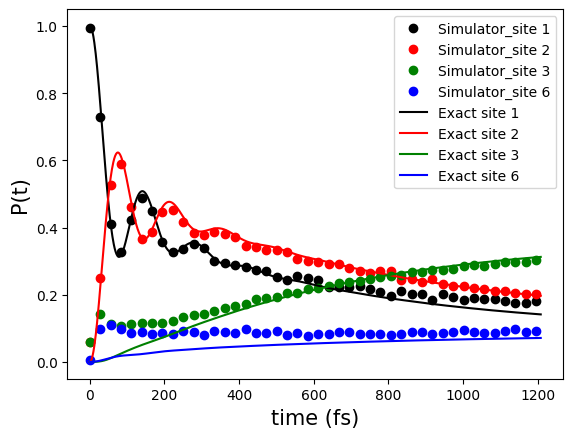

In [ ]:
str_back = 'Simulator'#'ibm_sherbrooke'

plt.plot(time_q,Pa_qs[:,0],'ko',label = str_back+'_site 1')
plt.plot(time_q,Pa_qs[:,1],'ro',label = str_back+'_site 2')
plt.plot(time_q,Pa_qs[:,2],'go',label = str_back+'_site 3')
plt.plot(time_q,Pa_qs[:,3],'bo',label = str_back+'_site 6')

plt.plot(time, popt[0,:].real,'k-', label = "Exact site 1")
plt.plot(time, popt[1,:].real,'r-', label = "Exact site 2")
plt.plot(time, popt[2,:].real,'g-', label = "Exact site 3")
plt.plot(time, popt[3,:].real,'b-', label = "Exact site 6")
plt.xlabel('time (fs)',fontsize=15)
plt.ylabel('P(t)',fontsize=15)
plt.legend(loc = 'upper right')
